# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

print(' TF Version:', tf.__version__, '\n', # 2.7.0
      'TFP Version:', tfp.__version__) # 0.15.0

 TF Version: 2.7.0 
 TFP Version: 0.15.0


# Deterministic Models - Experiments

In [2]:
def get_model(linear = True):
    initializers = ['he_normal', 'he_uniform', 'glorot_uniform', 'glorot_normal']
    if linear:
        return Sequential([Dense(1, kernel_initializer = np.random.choice(initializers))])
    else:
        return Sequential([Dense(128, activation = tf.nn.silu, kernel_initializer = np.random.choice(initializers)), 
                           Dense(64, activation = tf.nn.silu, kernel_initializer = np.random.choice(initializers)),
                           Dense(1)])

In [3]:
def run_experiment(linear = True):
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)
    if linear:
        
        x = np.linspace(-1, 1, 40)
        y = x + np.random.randn(x.shape[0]) * 0.2
        
        model1 = get_model()
        model1.compile(loss = 'mse', optimizer = optimizer)
        model1.fit(x.reshape(-1, 1), y, epochs = 100, verbose = 0)

        model2 = get_model()
        model2.compile(loss = 'mse', optimizer = optimizer)
        model2.fit(x.reshape(-1, 1), y, epochs = 100, verbose = 0)

        model3 = get_model()
        model3.compile(loss = 'mse', optimizer = optimizer)
        model3.fit(x.reshape(-1, 1), y, epochs = 100, verbose = 0)
    else:
        
        x = np.linspace(-5, 2, 400)
        y = 4 * x * np.cos(np.pi * np.sin(x)) + 1 + np.random.randn(x.shape[0]) * 0.5
        
        model1 = get_model(linear = False)
        model1.compile(loss = 'mse', optimizer = optimizer)
        model1.fit(x.reshape(-1, 1), y, epochs = 400, verbose = 0)

        model2 = get_model(linear = False)
        model2.compile(loss = 'mse', optimizer = optimizer)
        model2.fit(x.reshape(-1, 1), y, epochs = 400, verbose = 0)

        model3 = get_model(linear = False)
        model3.compile(loss = 'mse', optimizer = optimizer)
        model3.fit(x.reshape(-1, 1), y, epochs = 400, verbose = 0)
        
    print('Model1 Loss:' + str(model1.evaluate(x, y, verbose = False)))
    print('Model2 Loss:' + str(model2.evaluate(x, y, verbose = False)))
    print('Model3 Loss:' + str(model3.evaluate(x, y, verbose = False)))
    
    plt.figure(figsize = (13, 10))
    plt.scatter(x, y, color = 'gray', s = 70, alpha = 0.3, marker = "o", label = 'Data',
               linewidth = 3)
    plt.plot(x, model1.predict(x.reshape(-1, 1)), label = 'Model1', color = 'green', linewidth = 3)
    plt.plot(x, model2.predict(x.reshape(-1, 1)), label = 'Model2', color = 'red', linewidth = 3)
    plt.plot(x, model3.predict(x.reshape(-1, 1)), label = 'Model3', color = 'purple', linewidth = 3)
    plt.legend()
    plt.show()        

Model1 Loss:0.03348833695054054
Model2 Loss:0.03320697695016861
Model3 Loss:0.03331628441810608


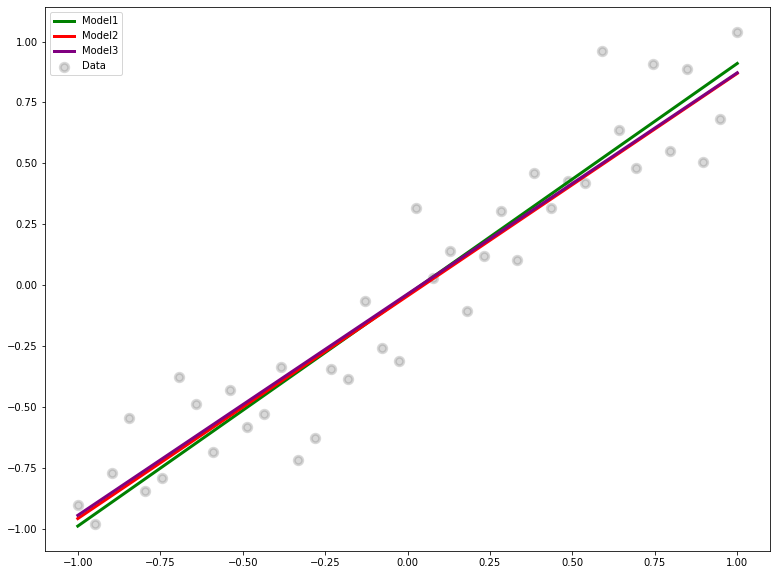

In [4]:
run_experiment(linear = True)

Model1 Loss:0.46694090962409973
Model2 Loss:0.544678270816803
Model3 Loss:0.9018436670303345


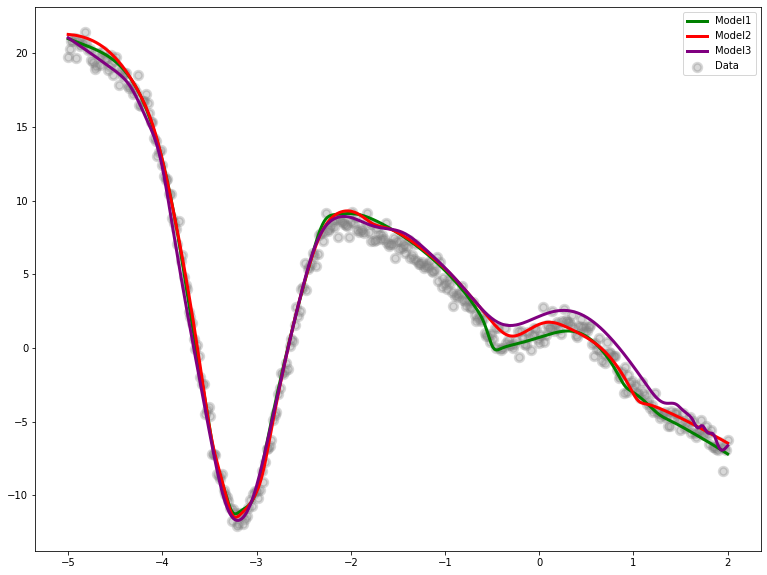

In [5]:
run_experiment(linear = False)

# Weight Uncertainty

In [2]:
?tfpl.DenseVariational

# Init signature: tfpl.DenseVariational(*args, **kwargs)
# Docstring:     
# Dense layer with random `kernel` and `bias`.

# This layer uses variational inference to fit a "surrogate" posterior to the
# distribution over both the `kernel` matrix and the `bias` terms which are
# otherwise used in a manner similar to `tf.keras.layers.Dense`.

# This layer fits the "weights posterior" according to the following generative
# process:

# ```none
# [K, b] ~ Prior()
# M = matmul(X, K) + b
# Y ~ Likelihood(M)
# ```
# Init docstring:
# Creates the `DenseVariational` layer.

# Args:
#   units: Positive integer, dimensionality of the output space.
#   make_posterior_fn: Python callable taking `tf.size(kernel)`,
#     `tf.size(bias)`, `dtype` and returns another callable which takes an
#     input and produces a `tfd.Distribution` instance.
#   make_prior_fn: Python callable taking `tf.size(kernel)`, `tf.size(bias)`,
#     `dtype` and returns another callable which takes an input and produces a
#     `tfd.Distribution` instance.
#   kl_weight: Amount by which to scale the KL divergence loss between prior
#     and posterior.
#   kl_use_exact: Python `bool` indicating that the analytical KL divergence
#     should be used rather than a Monte Carlo approximation.
#   activation: Activation function to use.
#     If you don't specify anything, no activation is applied
#     (ie. "linear" activation: `a(x) = x`).
#   use_bias: Boolean, whether the layer uses a bias vector.
#   activity_regularizer: Regularizer function applied to
#     the output of the layer (its "activation")..
#   **kwargs: Extra arguments forwarded to `tf.keras.layers.Layer`.

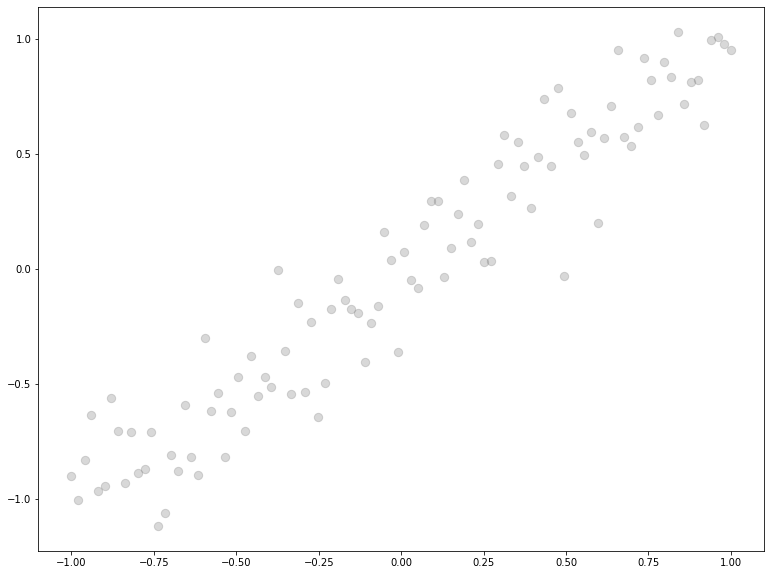

In [2]:
x_100 = np.linspace(-1, 1, 100)
y_100 = x_100 + np.random.randn(x_100.shape[0]) * 0.2

plt.figure(figsize = (13, 10))
plt.scatter(x_100, y_100, color = 'gray', s = 70, alpha = 0.3, marker = "o")

In [2]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfpl.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n),
    ])

In [4]:
model_100 = Sequential([
    tfpl.DenseVariational(input_shape = (1,),
                          units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x_100.shape[0])
])
model_100.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.003))
"""
we haven't put a distribution on the output, all the uncertainties in the weights.
So we can still use a normal deterministic loss-function
"""

model_100.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 1)                4         
 iational)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [5]:
model_100.fit(x_100, y_100, epochs=1000, verbose=0)
model_100.evaluate(x_100, y_100)

4/4 [==============================] - 0s 3ms/step - loss: 0.1015


0.1014782041311264

In [6]:
dummy = np.array([[0.0324]])
prior_protected = model_100.layers[0]._prior(dummy)
posterior_protected = model_100.layers[0]._posterior(dummy)
print('prior mean:', prior_protected.mean().numpy())
print('prior variance:', prior_protected.variance().numpy())
print('posterior mean:', posterior_protected.mean().numpy())
print('posterior variance:', posterior_protected.variance().numpy())

prior mean: [0. 0.]
prior variance: [1.9999999 1.9999999]
posterior mean: [ 0.99621785 -0.02372155]
posterior variance: [0.03062892 0.0123959 ]


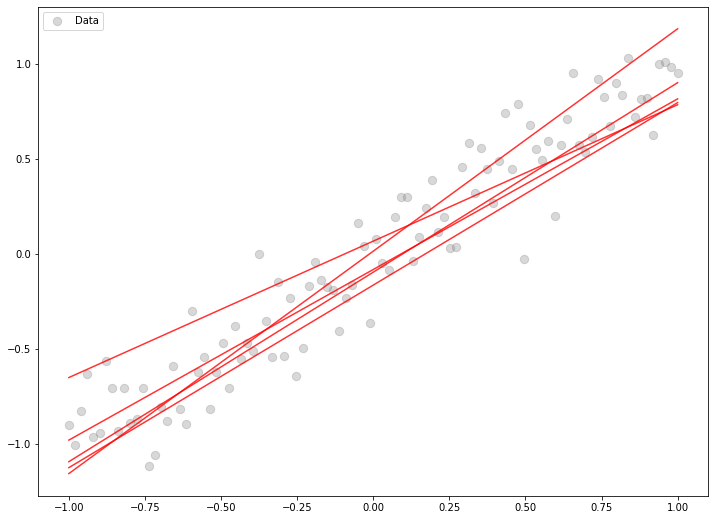

In [7]:
ensemble_size = 5

plt.figure(figsize=(12,9))
plt.scatter(x_100, y_100, s = 70, alpha = 0.3, marker = "o", label = 'Data', color = 'gray')
for _ in range(ensemble_size):
    plt.plot(x_100, model_100(x_100), color='red', alpha=0.8)        
plt.legend()
plt.show()

## More Data == Less Epistemic Uncertainty

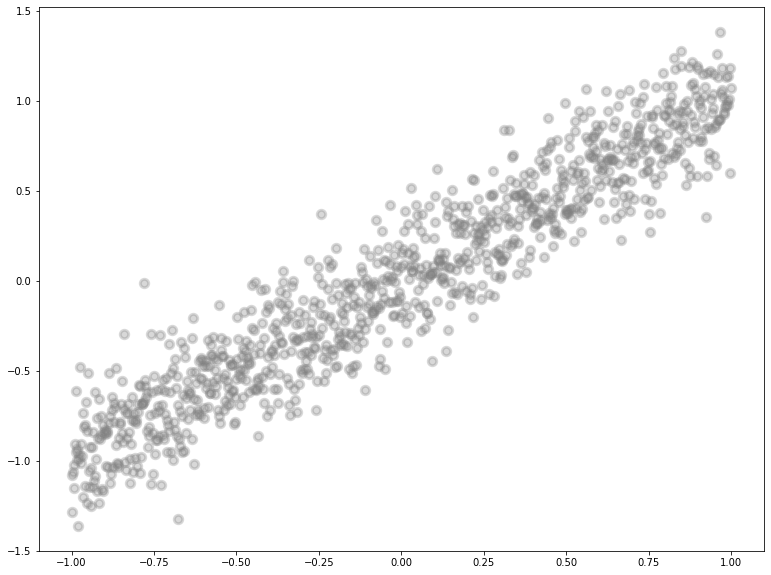

In [8]:
x_1000 = np.linspace(-1, 1, 1000)
y_1000 = x_1000 + np.random.randn(x_1000.shape[0]) * 0.2

plt.figure(figsize = (13, 10))
plt.scatter(x_1000, y_1000, color = 'gray', s = 70, alpha = 0.3, marker = "o", label = 'Data',
           linewidth = 3)

In [9]:
model_1000 = Sequential([
    tfpl.DenseVariational(input_shape = (1,),
                          units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x_1000.shape[0])
])
model_1000.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.003))
model_1000.fit(x_1000, y_1000, epochs=1000, verbose=0)
model_1000.evaluate(x_1000, y_1000)

32/32 [==============================] - 0s 3ms/step - loss: 0.0517


0.05174432322382927

In [13]:
model_1000.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_1 (DenseV  (None, 1)                4         
 ariational)                                                     
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


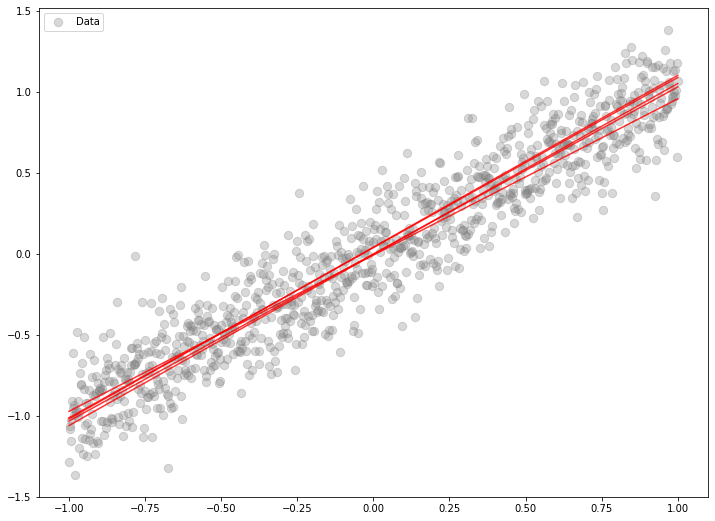

In [11]:
ensemble_size = 5

plt.figure(figsize=(12,9))
plt.scatter(x_1000, y_1000, s = 70, alpha = 0.3, marker = "o", label = 'Data', color = 'gray')
for _ in range(ensemble_size):
    plt.plot(x_1000, model_1000(x_1000), color='red', alpha=0.8)        
plt.legend()
plt.show()

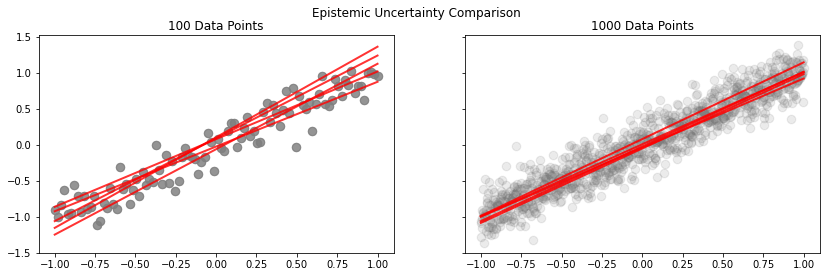

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
for _ in range(5):
    ax1.scatter(x_100, y_100, s = 70, alpha = 0.3, marker = "o", color = 'gray')
    ax1.plot(x_100, model_100(x_100), color='red', alpha=0.8, linewidth = 2)
    ax1.set_title('100 Data Points')
    
    ax2.scatter(x_1000, y_1000, s = 70, alpha = 0.03, marker = "o", color = 'gray')
    ax2.plot(x_1000, model_1000(x_1000), color='red', alpha=0.85, linewidth = 2)
    ax2.set_title('1000 Data Points')
    
    fig.suptitle('Epistemic Uncertainty Comparison')
plt.show()

## Non-Linear Data Epistemic Uncertainty

In [2]:
x = np.linspace(-5, 2, 400)
y = 4 * x * np.cos(np.pi * np.sin(x)) + 1 + np.random.randn(x.shape[0]) * 0.5

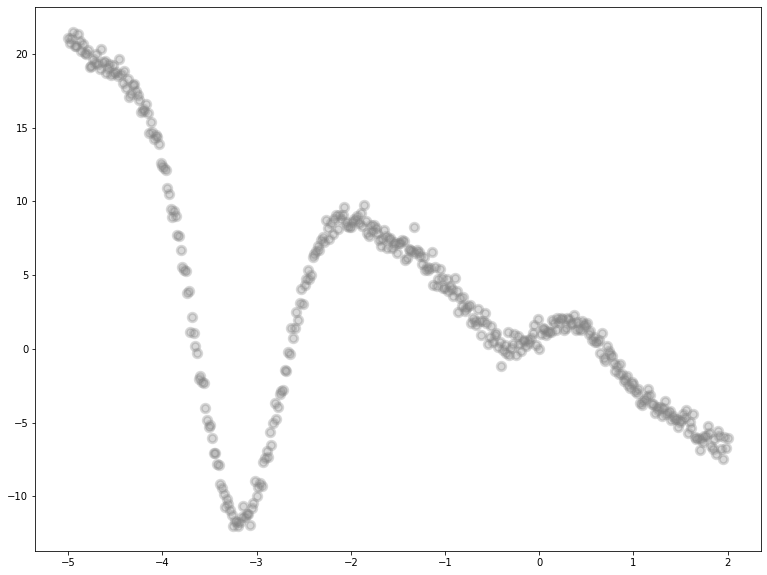

In [3]:
plt.figure(figsize = (13, 10))
plt.scatter(x, y, color = 'gray', s = 70, alpha = 0.3, marker = "o", label = 'Data',
           linewidth = 3)

In [4]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfpl.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [5]:
model_non_linear = Sequential([
    
    tfpl.DenseVariational(input_shape = (1,),
                          units = 128,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0], activation = tf.nn.silu),
    
    tfpl.DenseVariational(units = 64,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0], activation = tf.nn.silu),
    tfpl.DenseVariational(units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0])
])

model_non_linear.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = tf.keras.optimizers.Adam(lr = 0.003))
model_non_linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 128)              512       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 64)               16512     
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (None, 1)                130       
 ariational)                                                     
                                                                 
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_non_linear.fit(x, y, epochs=2000, verbose=False)
model_non_linear.evaluate(x, y)

13/13 [==============================] - 1s 5ms/step - loss: 17.3982


17.3981876373291

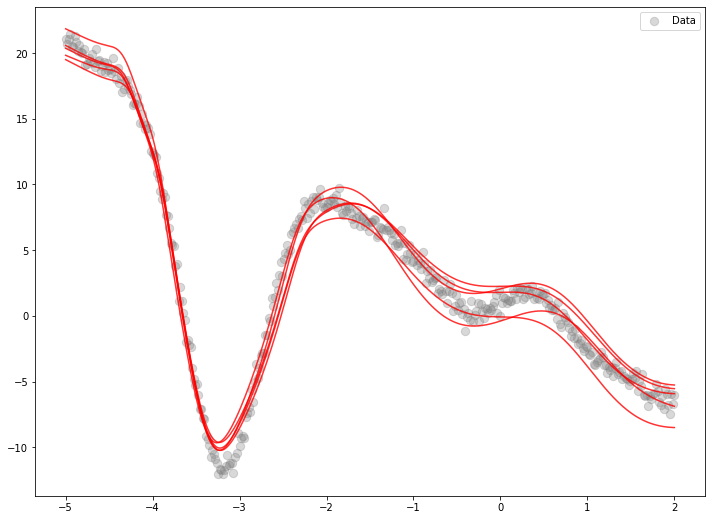

In [7]:
ensemble_size = 5

plt.figure(figsize=(12,9))
plt.scatter(x, y, s = 70, alpha = 0.3, marker = "o", label = 'Data', color = 'gray')
for _ in range(ensemble_size):
    plt.plot(x, model_non_linear(x), color='red', alpha=0.8)        
plt.legend()
plt.show()